# Adding Dynamic Features To Improve Energy Usage Predictions

For updates on the way Sagemaker or AWS behave compared to the notebook code, please refer to https://livebook.manning.com/#!/book/machine-learning-for-business/chapter-7/v-5/83

## Part 1: Load and examine the data

In [1]:
data_bucket = 'ml4-business'
subfolder = 'ch07'
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In [2]:
%matplotlib inline

from dateutil.parser import parse
import json
import random
import datetime
import os
from time import sleep

import pandas as pd                               
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

role = sagemaker.get_execution_role()
s3 = s3fs.S3FileSystem(anon=False)
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

In this chapter we will be dealing with 5 files. Our meter readings have already been summarised into daily totals and can be found in "Meter Data.csv". We also have a "Site Categories.csv" file which records whether each site belongs to the Retail, Industrial, or Transport industries. We will use this as a static "Category" feature. There is a further file which contains time series data regarding holidays. This is "Site Holidays.csv". Finally we have maximum temperatures in "Site Maxima.csv" These will be our models "dynamic features".

In [3]:
# First we check our meter data
daily_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/meter_data_daily.csv', index_col=0, parse_dates=[0])
daily_df.index.name = None
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_46,Site_47,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,NaN,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,NaN,NaN,NaN,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,NaN,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,NaN,NaN,NaN,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,NaN,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,NaN,NaN,NaN,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,NaN,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,NaN,NaN,NaN,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,NaN,5221.5,929.4,1068.0,767.7,785.8,...,318.24,NaN,NaN,NaN,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [4]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


In [5]:
category_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_categories.csv',index_col=0).reset_index(drop=True)
print(category_df.shape)
print(category_df.Category.unique())
category_df.head()

(48, 2)
['Retail' 'Industrial ' 'Transport']


,Site,Category
0,1,Retail
1,2,Retail
2,3,Retail
3,4,Retail
4,5,Retail


In [6]:
holiday_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_holidays.csv', index_col=0, parse_dates=[0])
print(holiday_df.shape)
print(f'Time series starts at {holiday_df.index[0]} and ends at {holiday_df.index[-1]}')
holiday_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_hol,Site_2_hol,Site_3_hol,Site_4_hol,Site_5_hol,Site_6_hol,Site_7_hol,Site_8_hol,Site_9_hol,Site_10_hol,...,Site_39_hol,Site_40_hol,Site_41_hol,Site_42_hol,Site_43_hol,Site_44_hol,Site_45_hol,Site_46_hol,Site_47_hol,Site_48_hol
2018-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-24,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
2018-12-25,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-26,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
max_df = pd.read_csv(f's3://{data_bucket}/{subfolder}/site_maximums.csv', index_col=0, parse_dates=[0])
print(max_df.shape)
print(f'Time series starts at {max_df.index[0]} and ends at {max_df.index[-1]}')
max_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_max,Site_2_max,Site_3_max,Site_4_max,Site_5_max,Site_6_max,Site_7_max,Site_8_max,Site_9_max,Site_10_max,...,Site_39_max,Site_40_max,Site_41_max,Site_42_max,Site_43_max,Site_44_max,Site_45_max,Site_46_max,Site_47_max,Site_48_max
2018-12-22,21.5,23.4,24.9,23.1,24.9,25.2,23.4,24.9,23.4,23.9,...,33.2,20.4,20.4,24.9,21.5,21.1,21.1,18.9,18.9,40.9
2018-12-23,29.5,28.4,30.9,27.0,30.9,30.8,28.4,30.9,28.4,30.4,...,27.4,25.5,25.5,30.9,22.6,23.4,23.4,24.5,24.5,34.9
2018-12-24,33.3,35.2,36.6,35.1,36.6,37.0,35.2,36.6,35.2,36.4,...,27.0,33.8,33.8,36.6,25.4,26.8,26.8,33.9,33.9,33.6
2018-12-25,34.7,34.8,37.8,32.4,37.8,37.9,34.8,37.8,34.8,37.5,...,27.1,25.1,25.1,37.8,29.7,30.1,30.1,23.8,23.8,33.8
2018-12-26,37.5,34.8,40.0,32.8,40.0,39.5,34.8,40.0,34.8,40.1,...,27.2,30.2,30.2,40.0,30.5,31.8,31.8,23.7,23.7,29.6
2018-12-27,39.3,41.3,42.8,40.9,42.8,43.7,41.3,42.8,41.3,43.9,...,28.1,36.7,36.7,42.8,32.4,32.4,32.4,33.9,33.9,27.1


## Part 2: Get the data in the right shape

In [8]:
# We need to do this to set freq='D' on the index:
daily_df = daily_df.resample('D').sum()
daily_df = daily_df.replace([0],[None])

In [9]:
daily_df[daily_df.isnull().any(axis=1)].index

DatetimeIndex(['2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
               '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18', '2017-11-19', '2017-11-20',
               '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24',
               '2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', freq='D')

Some sites have missing values for November 2017. We will not impute these but instead train with missing values.
During the prediction step we will only use values from December. So daily_df is already in the right shape!

In [10]:
# How about categoricals?
print(f'{len(category_df[category_df.isnull().any(axis=1)])} sites with missing categories.')

0 sites with missing categories.


In [11]:
# Dynamic features?
print(f'{len(holiday_df[holiday_df.isnull().any(axis=1)])} days with missing holidays.')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures.')

0 days with missing holidays.
54 days with missing maximum temperatures.


In [12]:
# So we have to impute missing temperatures. Weather does not follow a weekly cycle like energy usage does,
# but pandas has a very nice way to impute missing values for this very situation:
max_df = max_df.interpolate(method='time')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures. Problem solved!')

0 days with missing maximum temperatures. Problem solved!


Number of time series: 48


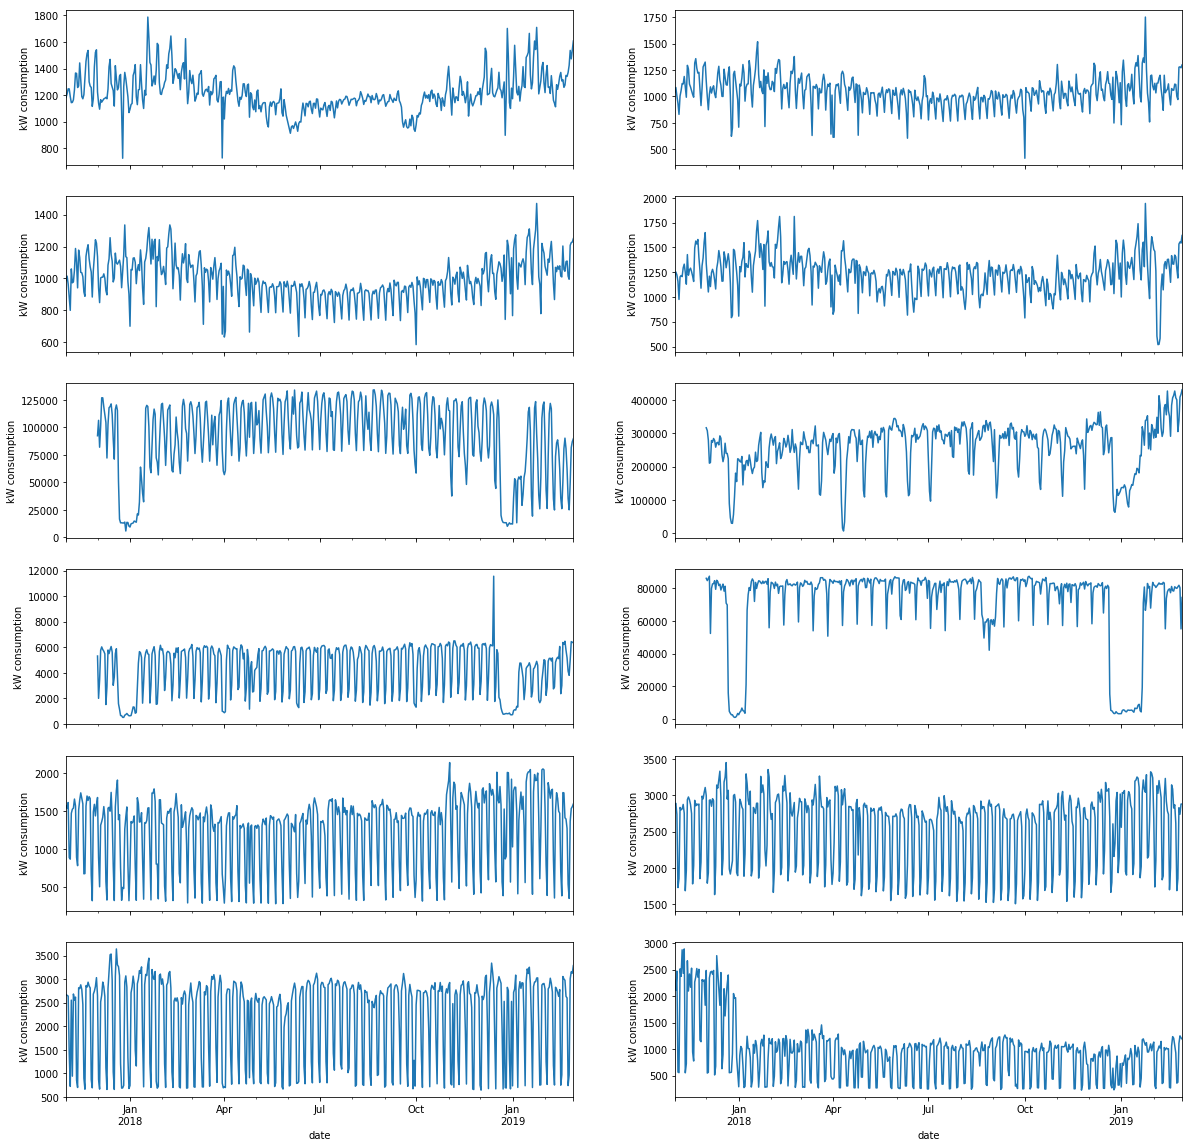

In [13]:
# Confirm visually we are dealing with the same or similar data to chapter 6:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(6, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,26,27,33,39,42,43,46,47]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2019-02-28"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

## Part 3: Create Train and Test Datasets

In [14]:
cats = list(category_df.Category.astype('category').cat.codes)
print(cats)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2]


In [15]:
usage_per_site = [daily_df[col] for col in daily_df.columns]

print(f'Time series covers {len(usage_per_site[0])} days.')
print(f'Time series starts at {usage_per_site[0].index[0]}')
print(f'Time series ends at {usage_per_site[0].index[-1]}') 
usage_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    1184.23
2017-11-02     1210.9
2017-11-03     1247.6
2017-11-04    1246.92
2017-11-05     1189.2
2017-11-06    1143.62
2017-11-07    1145.66
2017-11-08     1165.5
2017-11-09    1239.25
2017-11-10    1366.25
Freq: D, Name: Site_1, dtype: object

In [16]:
# Do the same for our dynamic features
hols_per_site = [holiday_df[col] for col in holiday_df.columns]
    
print(f'Time series covers {len(hols_per_site[0])} days.')
print(f'Time series starts at {hols_per_site[0].index[0]}')
print(f'Time series ends at {hols_per_site[0].index[-1]}') 
hols_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    0
2017-11-02    0
2017-11-03    0
2017-11-04    0
2017-11-05    0
2017-11-06    0
2017-11-07    0
2017-11-08    0
2017-11-09    0
2017-11-10    0
Name: Site_1_hol, dtype: int64

In [17]:
max_per_site = [max_df[col] for col in max_df.columns]
    
print(f'Time series covers {len(max_per_site[0])} days.')
print(f'Time series starts at {max_per_site[0].index[0]}')
print(f'Time series ends at {max_per_site[0].index[-1]}') 
max_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    20.5
2017-11-02    20.9
2017-11-03    16.2
2017-11-04    18.2
2017-11-05    22.1
2017-11-06    17.2
2017-11-07    17.5
2017-11-08    23.1
2017-11-09    28.5
2017-11-10    31.7
Name: Site_1_max, dtype: float64

In [18]:
freq = 'D'
prediction_length = 28

start_date = pd.Timestamp("2017-11-01", freq=freq)
end_training = pd.Timestamp("2019-01-31", freq=freq)
end_testing = end_training + prediction_length*start_date.freq

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2019-01-31 00:00:00, End testing: 2019-02-28 00:00:00


In [19]:
def write_dicts_to_s3(path, data):
    with s3.open(path, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))

In [20]:
# NOTE: We have missing values in ts for November only.
#       Dynamic features must have numeric values for every entry.
training_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist(),
        "dynamic_feat": [
            hols[start_date:end_training].tolist(),
            maxes[start_date:end_training].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]

test_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist(),
        "dynamic_feat": [
            hols[start_date:end_testing].tolist(),
            maxes[start_date:end_testing].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]
            
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

## Part 4: Set up session and configure model

In [21]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(sess.boto_region_name, "forecasting-deepar", "latest")

data_channels = {
    "train": f"{s3_data_path}/train/",
    "test": f"{s3_data_path}/test/"
}
np.random.seed(42)
random.seed(42)

In [22]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
# Reuse the class from Chapter 6:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

## Part 5a: Create model without using additional datasets

First, we will establish a baseline without categorical or dynamic features. Note that this cell is commented out as you only need to run it if you want to see the MAPE without incorporating additional datasets.

In [24]:
# estimator = sagemaker.estimator.Estimator(
#     sagemaker_session=sess,
#     image_name=image_name,
#     role=role,
#     train_instance_count=1,
#     train_instance_type='ml.m4.xlarge',
#     base_job_name='ch7-energy-usage-baseline',
#     output_path=s3_output_path
# )

# estimator.set_hyperparameters(
#     cardinality='ignore', # DISABLES CATEGORICALS FOR BASELINE
#     context_length="90",
#     prediction_length=str(prediction_length),
#     time_freq=freq,
#     epochs="400",
#     early_stopping_patience="40",
#     mini_batch_size="64",
#     learning_rate="5E-4",
#     num_dynamic_feat="ignore", # DISABLE DYNAMIC FEATURES FOR BASELINE
# )

# estimator.fit(inputs=data_channels, wait=True)

# endpoint_name = 'energy-usage-baseline'

# try:
#     sess.delete_endpoint(endpoint_name)
#     print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
#     sleep(30)
# except:
#     pass

# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m4.xlarge',
#     predictor_cls=DeepARPredictor,
#     endpoint_name=endpoint_name)

# # Gather 28 day predictions for all timeseries
# usages = [ts[end_training+1:end_training+28].sum() for ts in usage_per_site]

# predictions= []
# for s in range(len(usage_per_site)):
#     # call the end point to get the 28 day prediction
#     predictions.append(
#         predictor.predict(
#             ts=usage_per_site[s][start_date+30:end_training],
#         )['0.5'].sum()
#     )
    
# print(f'MAPE: {round(mape(usages, predictions),1)}%')    

## Part 5b: Model incorporating additional datasets

In [25]:
%%time
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='ch7-energy-usage-dynamic',
    output_path=s3_output_path
)

estimator.set_hyperparameters(
    context_length="90",
    prediction_length=str(prediction_length),
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    num_dynamic_feat=2,
)

estimator.fit(inputs=data_channels, wait=True)

2020-06-25 21:34:53 Starting - Starting the training job...
2020-06-25 21:34:55 Starting - Launching requested ML instances......
2020-06-25 21:36:13 Starting - Preparing the instances for training......
2020-06-25 21:37:20 Downloading - Downloading input data......
2020-06-25 21:38:20 Training - Training image download completed. Training in progress..Arguments: train
[06/25/2020 21:38:23 INFO 140589383042880] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patienc

[06/25/2020 21:38:39 INFO 140589383042880] Epoch[6] Batch[0] avg_epoch_loss=7.123982
[06/25/2020 21:38:39 INFO 140589383042880] #quality_metric: host=algo-1, epoch=6, batch=0 train loss <loss>=7.1239824295
[06/25/2020 21:38:40 INFO 140589383042880] Epoch[6] Batch[5] avg_epoch_loss=6.825632
[06/25/2020 21:38:40 INFO 140589383042880] #quality_metric: host=algo-1, epoch=6, batch=5 train loss <loss>=6.82563153903
[06/25/2020 21:38:40 INFO 140589383042880] Epoch[6] Batch [5]#011Speed: 358.06 samples/sec#011loss=6.825632
[06/25/2020 21:38:41 INFO 140589383042880] Epoch[6] Batch[10] avg_epoch_loss=7.007537
[06/25/2020 21:38:41 INFO 140589383042880] #quality_metric: host=algo-1, epoch=6, batch=10 train loss <loss>=7.22582464218
[06/25/2020 21:38:41 INFO 140589383042880] Epoch[6] Batch [10]#011Speed: 338.16 samples/sec#011loss=7.225825
[06/25/2020 21:38:41 INFO 140589383042880] processed a total of 647 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2311.5830421447754, "sum": 

[06/25/2020 21:39:04 INFO 140589383042880] Epoch[17] Batch[0] avg_epoch_loss=6.468873
[06/25/2020 21:39:04 INFO 140589383042880] #quality_metric: host=algo-1, epoch=17, batch=0 train loss <loss>=6.46887302399
[06/25/2020 21:39:05 INFO 140589383042880] Epoch[17] Batch[5] avg_epoch_loss=6.687327
[06/25/2020 21:39:05 INFO 140589383042880] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=6.68732690811
[06/25/2020 21:39:05 INFO 140589383042880] Epoch[17] Batch [5]#011Speed: 358.09 samples/sec#011loss=6.687327
[06/25/2020 21:39:06 INFO 140589383042880] Epoch[17] Batch[10] avg_epoch_loss=6.782230
[06/25/2020 21:39:06 INFO 140589383042880] #quality_metric: host=algo-1, epoch=17, batch=10 train loss <loss>=6.89611368179
[06/25/2020 21:39:06 INFO 140589383042880] Epoch[17] Batch [10]#011Speed: 343.59 samples/sec#011loss=6.896114
[06/25/2020 21:39:06 INFO 140589383042880] processed a total of 729 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2489.5999431610107

[06/25/2020 21:39:20 INFO 140589383042880] Epoch[23] Batch[10] avg_epoch_loss=6.475878
[06/25/2020 21:39:20 INFO 140589383042880] #quality_metric: host=algo-1, epoch=23, batch=10 train loss <loss>=6.48257226944
[06/25/2020 21:39:20 INFO 140589383042880] Epoch[23] Batch [10]#011Speed: 350.19 samples/sec#011loss=6.482572
[06/25/2020 21:39:20 INFO 140589383042880] processed a total of 683 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2305.3689002990723, "sum": 2305.3689002990723, "min": 2305.3689002990723}}, "EndTime": 1593121160.202356, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121157.896918}

[06/25/2020 21:39:20 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=296.248098443 records/second
[06/25/2020 21:39:20 INFO 140589383042880] #progress_metric: host=algo-1, completed 6 % of epochs
[06/25/2020 21:39:20 INFO 140589383042880] #quality_metric: host=algo-1, epoch=23, train loss <loss>

[06/25/2020 21:39:34 INFO 140589383042880] Epoch[30] Batch[5] avg_epoch_loss=6.139220
[06/25/2020 21:39:34 INFO 140589383042880] #quality_metric: host=algo-1, epoch=30, batch=5 train loss <loss>=6.13922007879
[06/25/2020 21:39:34 INFO 140589383042880] Epoch[30] Batch [5]#011Speed: 351.33 samples/sec#011loss=6.139220
[06/25/2020 21:39:35 INFO 140589383042880] Epoch[30] Batch[10] avg_epoch_loss=6.261115
[06/25/2020 21:39:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=30, batch=10 train loss <loss>=6.40738964081
[06/25/2020 21:39:35 INFO 140589383042880] Epoch[30] Batch [10]#011Speed: 339.27 samples/sec#011loss=6.407390
[06/25/2020 21:39:35 INFO 140589383042880] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2329.890012741089, "sum": 2329.890012741089, "min": 2329.890012741089}}, "EndTime": 1593121175.606507, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121173.275781}

[06/2

[06/25/2020 21:39:55 INFO 140589383042880] Epoch[39] Batch[5] avg_epoch_loss=6.383347
[06/25/2020 21:39:55 INFO 140589383042880] #quality_metric: host=algo-1, epoch=39, batch=5 train loss <loss>=6.38334743182
[06/25/2020 21:39:55 INFO 140589383042880] Epoch[39] Batch [5]#011Speed: 355.45 samples/sec#011loss=6.383347
[06/25/2020 21:39:55 INFO 140589383042880] processed a total of 619 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2178.879976272583, "sum": 2178.879976272583, "min": 2178.879976272583}}, "EndTime": 1593121195.806767, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121193.627813}

[06/25/2020 21:39:55 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=284.073318627 records/second
[06/25/2020 21:39:55 INFO 140589383042880] #progress_metric: host=algo-1, completed 10 % of epochs
[06/25/2020 21:39:55 INFO 140589383042880] #quality_metric: host=algo-1, epoch=39, train loss <loss>=6.39

[06/25/2020 21:40:15 INFO 140589383042880] Epoch[48] Batch[5] avg_epoch_loss=6.090418
[06/25/2020 21:40:15 INFO 140589383042880] #quality_metric: host=algo-1, epoch=48, batch=5 train loss <loss>=6.09041833878
[06/25/2020 21:40:15 INFO 140589383042880] Epoch[48] Batch [5]#011Speed: 355.02 samples/sec#011loss=6.090418
[06/25/2020 21:40:15 INFO 140589383042880] Epoch[48] Batch[10] avg_epoch_loss=6.076811
[06/25/2020 21:40:15 INFO 140589383042880] #quality_metric: host=algo-1, epoch=48, batch=10 train loss <loss>=6.06048231125
[06/25/2020 21:40:15 INFO 140589383042880] Epoch[48] Batch [10]#011Speed: 350.60 samples/sec#011loss=6.060482
[06/25/2020 21:40:15 INFO 140589383042880] processed a total of 643 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2289.570093154907, "sum": 2289.570093154907, "min": 2289.570093154907}}, "EndTime": 1593121215.973937, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121213.683891}

[06/2

[06/25/2020 21:40:35 INFO 140589383042880] Epoch[57] Batch[5] avg_epoch_loss=6.056515
[06/25/2020 21:40:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=57, batch=5 train loss <loss>=6.05651450157
[06/25/2020 21:40:35 INFO 140589383042880] Epoch[57] Batch [5]#011Speed: 358.49 samples/sec#011loss=6.056515
[06/25/2020 21:40:35 INFO 140589383042880] processed a total of 637 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2097.8171825408936, "sum": 2097.8171825408936, "min": 2097.8171825408936}}, "EndTime": 1593121235.750006, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121233.651341}

[06/25/2020 21:40:35 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=303.631910305 records/second
[06/25/2020 21:40:35 INFO 140589383042880] #progress_metric: host=algo-1, completed 14 % of epochs
[06/25/2020 21:40:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=57, train loss <loss>=6

[06/25/2020 21:40:54 INFO 140589383042880] Epoch[66] Batch[5] avg_epoch_loss=6.325850
[06/25/2020 21:40:54 INFO 140589383042880] #quality_metric: host=algo-1, epoch=66, batch=5 train loss <loss>=6.32584953308
[06/25/2020 21:40:54 INFO 140589383042880] Epoch[66] Batch [5]#011Speed: 359.97 samples/sec#011loss=6.325850
[06/25/2020 21:40:55 INFO 140589383042880] processed a total of 632 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2100.4741191864014, "sum": 2100.4741191864014, "min": 2100.4741191864014}}, "EndTime": 1593121255.692788, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121253.591719}

[06/25/2020 21:40:55 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=300.859110936 records/second
[06/25/2020 21:40:55 INFO 140589383042880] #progress_metric: host=algo-1, completed 16 % of epochs
[06/25/2020 21:40:55 INFO 140589383042880] #quality_metric: host=algo-1, epoch=66, train loss <loss>=6

[06/25/2020 21:41:14 INFO 140589383042880] Epoch[75] Batch[5] avg_epoch_loss=6.232974
[06/25/2020 21:41:14 INFO 140589383042880] #quality_metric: host=algo-1, epoch=75, batch=5 train loss <loss>=6.23297381401
[06/25/2020 21:41:14 INFO 140589383042880] Epoch[75] Batch [5]#011Speed: 355.08 samples/sec#011loss=6.232974
[06/25/2020 21:41:15 INFO 140589383042880] processed a total of 570 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1966.8688774108887, "sum": 1966.8688774108887, "min": 1966.8688774108887}}, "EndTime": 1593121275.081843, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121273.114384}

[06/25/2020 21:41:15 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=289.780092271 records/second
[06/25/2020 21:41:15 INFO 140589383042880] #progress_metric: host=algo-1, completed 19 % of epochs
[06/25/2020 21:41:15 INFO 140589383042880] #quality_metric: host=algo-1, epoch=75, train loss <loss>=6

[06/25/2020 21:41:35 INFO 140589383042880] Epoch[84] Batch[10] avg_epoch_loss=6.158465
[06/25/2020 21:41:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=84, batch=10 train loss <loss>=6.11397075653
[06/25/2020 21:41:35 INFO 140589383042880] Epoch[84] Batch [10]#011Speed: 346.98 samples/sec#011loss=6.113971
[06/25/2020 21:41:35 INFO 140589383042880] processed a total of 676 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2334.012985229492, "sum": 2334.012985229492, "min": 2334.012985229492}}, "EndTime": 1593121295.09183, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121292.757745}

[06/25/2020 21:41:35 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=289.615041701 records/second
[06/25/2020 21:41:35 INFO 140589383042880] #progress_metric: host=algo-1, completed 21 % of epochs
[06/25/2020 21:41:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=84, train loss <loss>=6.

[06/25/2020 21:41:54 INFO 140589383042880] processed a total of 621 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2171.502113342285, "sum": 2171.502113342285, "min": 2171.502113342285}}, "EndTime": 1593121314.955148, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121312.783119}

[06/25/2020 21:41:54 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=285.960045386 records/second
[06/25/2020 21:41:54 INFO 140589383042880] #progress_metric: host=algo-1, completed 23 % of epochs
[06/25/2020 21:41:54 INFO 140589383042880] #quality_metric: host=algo-1, epoch=93, train loss <loss>=5.98412270546
[06/25/2020 21:41:54 INFO 140589383042880] loss did not improve
[06/25/2020 21:41:55 INFO 140589383042880] Epoch[94] Batch[0] avg_epoch_loss=6.025300
[06/25/2020 21:41:55 INFO 140589383042880] #quality_metric: host=algo-1, epoch=94, batch=0 train loss <loss>=6.0252995491
[06/25/2020 21:41:56 INFO 1405893830

[06/25/2020 21:42:14 INFO 140589383042880] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2224.3499755859375, "sum": 2224.3499755859375, "min": 2224.3499755859375}}, "EndTime": 1593121334.90694, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121332.68216}

[06/25/2020 21:42:14 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=285.012884262 records/second
[06/25/2020 21:42:14 INFO 140589383042880] #progress_metric: host=algo-1, completed 25 % of epochs
[06/25/2020 21:42:14 INFO 140589383042880] #quality_metric: host=algo-1, epoch=102, train loss <loss>=6.145941782
[06/25/2020 21:42:14 INFO 140589383042880] loss did not improve
[06/25/2020 21:42:15 INFO 140589383042880] Epoch[103] Batch[0] avg_epoch_loss=5.700476
[06/25/2020 21:42:15 INFO 140589383042880] #quality_metric: host=algo-1, epoch=103, batch=0 train loss <loss>=5.70047616959
[06/25/2020 21:42:16 INFO 1405893

[06/25/2020 21:42:35 INFO 140589383042880] Epoch[111] Batch[10] avg_epoch_loss=6.139147
[06/25/2020 21:42:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=111, batch=10 train loss <loss>=6.20271911621
[06/25/2020 21:42:35 INFO 140589383042880] Epoch[111] Batch [10]#011Speed: 348.86 samples/sec#011loss=6.202719
[06/25/2020 21:42:35 INFO 140589383042880] processed a total of 681 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2311.8550777435303, "sum": 2311.8550777435303, "min": 2311.8550777435303}}, "EndTime": 1593121355.420303, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121353.107957}

[06/25/2020 21:42:35 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=294.553752648 records/second
[06/25/2020 21:42:35 INFO 140589383042880] #progress_metric: host=algo-1, completed 28 % of epochs
[06/25/2020 21:42:35 INFO 140589383042880] #quality_metric: host=algo-1, epoch=111, train loss <

[06/25/2020 21:42:54 INFO 140589383042880] Epoch[120] Batch[5] avg_epoch_loss=5.988932
[06/25/2020 21:42:54 INFO 140589383042880] #quality_metric: host=algo-1, epoch=120, batch=5 train loss <loss>=5.9889318943
[06/25/2020 21:42:54 INFO 140589383042880] Epoch[120] Batch [5]#011Speed: 357.13 samples/sec#011loss=5.988932
[06/25/2020 21:42:55 INFO 140589383042880] Epoch[120] Batch[10] avg_epoch_loss=6.044932
[06/25/2020 21:42:55 INFO 140589383042880] #quality_metric: host=algo-1, epoch=120, batch=10 train loss <loss>=6.11213150024
[06/25/2020 21:42:55 INFO 140589383042880] Epoch[120] Batch [10]#011Speed: 350.22 samples/sec#011loss=6.112132
[06/25/2020 21:42:55 INFO 140589383042880] processed a total of 671 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2288.4011268615723, "sum": 2288.4011268615723, "min": 2288.4011268615723}}, "EndTime": 1593121375.571715, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121373.282417


2020-06-25 21:43:30 Uploading - Uploading generated training model[06/25/2020 21:43:14 INFO 140589383042880] Epoch[129] Batch[5] avg_epoch_loss=6.072979
[06/25/2020 21:43:14 INFO 140589383042880] #quality_metric: host=algo-1, epoch=129, batch=5 train loss <loss>=6.07297889392
[06/25/2020 21:43:14 INFO 140589383042880] Epoch[129] Batch [5]#011Speed: 338.31 samples/sec#011loss=6.072979
[06/25/2020 21:43:15 INFO 140589383042880] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2142.179012298584, "sum": 2142.179012298584, "min": 2142.179012298584}}, "EndTime": 1593121395.601646, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1593121393.458834}

[06/25/2020 21:43:15 INFO 140589383042880] #throughput_metric: host=algo-1, train throughput=295.941255768 records/second
[06/25/2020 21:43:15 INFO 140589383042880] #progress_metric: host=algo-1, completed 32 % of epochs
[06/25/2020 21:43:15 INFO 140589383


2020-06-25 21:43:36 Completed - Training job completed
Training seconds: 376
Billable seconds: 376
CPU times: user 1.42 s, sys: 73.6 ms, total: 1.49 s
Wall time: 9min 17s


## Part 6. Making predictions from the model that incorporates additional datasets

In [26]:
endpoint_name = 'energy-usage-dynamic'

try:
    sess.delete_endpoint(endpoint_name)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
    sleep(30)
except:
    pass

In [27]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name)

---------------!CPU times: user 261 ms, sys: 18.9 ms, total: 280 ms
Wall time: 7min 32s


In [28]:
# Test prediction: (Delete endpoint configuration if retrying)
frq=start_date.freq
predictor.predict(
    cat=[cats[0]],
    ts=usage_per_site[0][start_date+30*frq:end_training],
     dynamic_feat=[
             hols_per_site[0][start_date+30*frq:end_training+28*frq].tolist(),
             max_per_site[0][start_date+30*frq:end_training+28*frq].tolist(),
         ],
    quantiles=[0.1, 0.5, 0.9]
).head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-02-01,1130.712158,1402.644287,1274.331299
2019-02-02,1106.585205,1392.121460,1265.364990
2019-02-03,1259.590088,1574.647949,1395.313232
2019-02-04,1318.955811,1575.068848,1415.682861
2019-02-05,1244.425293,1475.378296,1358.523193


In [29]:
# Gather 28 day predictions for all timeseries
usages = [ts[end_training+1*frq:end_training+28*frq].sum() for ts in usage_per_site]

predictions= []
for s in range(len(usage_per_site)):
    # call the end point to get the 28 day prediction
    predictions.append(
        predictor.predict(
            cat=[cats[s]],
            ts=usage_per_site[s][start_date+30*frq:end_training],
            dynamic_feat=[
                hols_per_site[s][start_date+30*frq:end_training+28*frq].tolist(),
                max_per_site[s][start_date+30*frq:end_training+28*frq].tolist(),
             ]
        )['0.5'].sum()
    )

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh.')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


Predicted 38195.36389160171 kwh but usage was 37068.36 kwh.
Predicted 31694.8254394529 kwh but usage was 30693.799999999992 kwh.
Predicted 31046.4307250978 kwh but usage was 30511.63000000001 kwh.
Predicted 38323.814941406396 kwh but usage was 34640.020000000004 kwh.
Predicted 33032.935607910105 kwh but usage was 31308.799999999996 kwh.
Predicted 219162.99609375 kwh but usage was 214708.80000000005 kwh.
Predicted 26093.497436523303 kwh but usage was 26765.299999999996 kwh.
Predicted 22876.840881348096 kwh but usage was 21487.999999999996 kwh.
Predicted 33087.985900878695 kwh but usage was 32996.99999999999 kwh.
Predicted 19126.8737487792 kwh but usage was 16920.5 kwh.
Predicted 36057.5112915038 kwh but usage was 34510.01999999999 kwh.
Predicted 36697.4249877928 kwh but usage was 35310.399999999994 kwh.
Predicted 23855.6319580077 kwh but usage was 19524.100000000006 kwh.
Predicted 32984.2793579104 kwh but usage was 33006.7 kwh.
Predicted 36256.3471069336 kwh but usage was 35398.20000000

In [30]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 10.3%


That's a really impressive improvement from 21%. What does this look like visually?

In [31]:
def plot(
    predictor, 
    site_id,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    frq = end_training.freq
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
    target_ts = usage_per_site[site_id][start_date+30*frq:]
    dynamic_feats = [
            hols_per_site[site_id][start_date+30*frq:].tolist(),
            max_per_site[site_id][start_date+30*frq:].tolist(),
        ]
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(
        cat = [cats[site_id]],
        ts=target_ts[:end_training],
        dynamic_feat=dynamic_feats,
        quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-plot_history*frq:end_training+prediction_length*frq]
    target_section.plot(color="black", label='target')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )  
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
/home/ec2-user/anaconda3/e

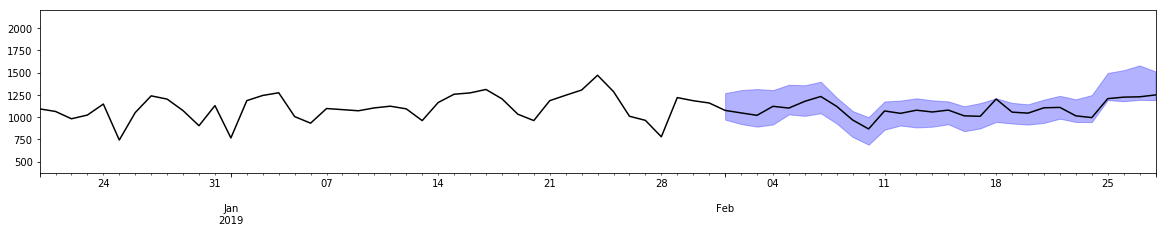

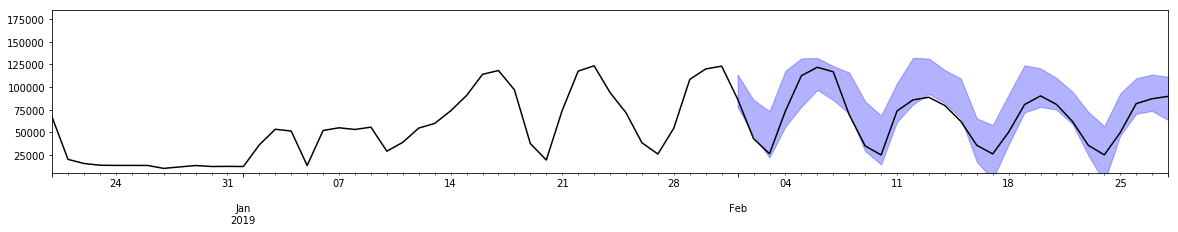

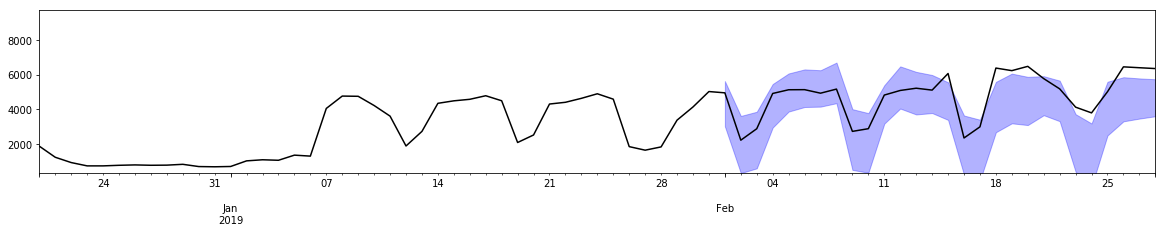

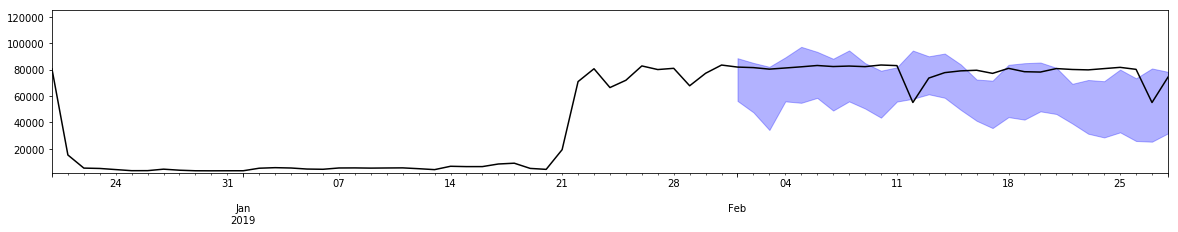

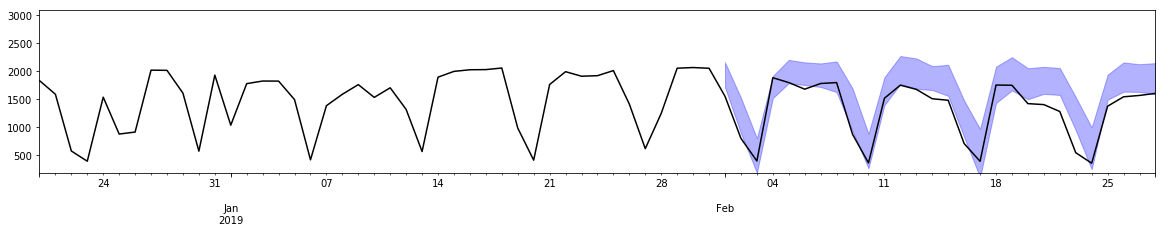

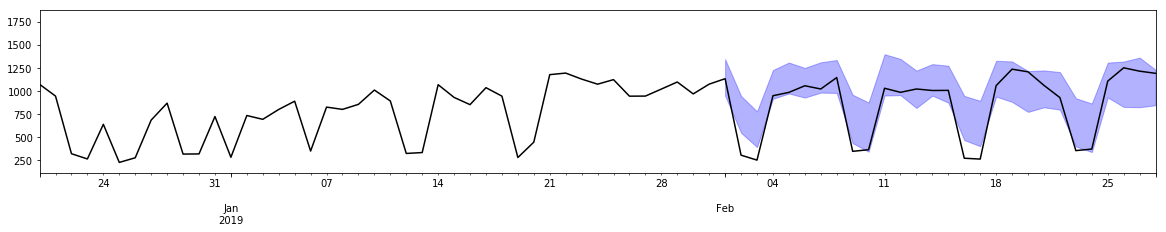

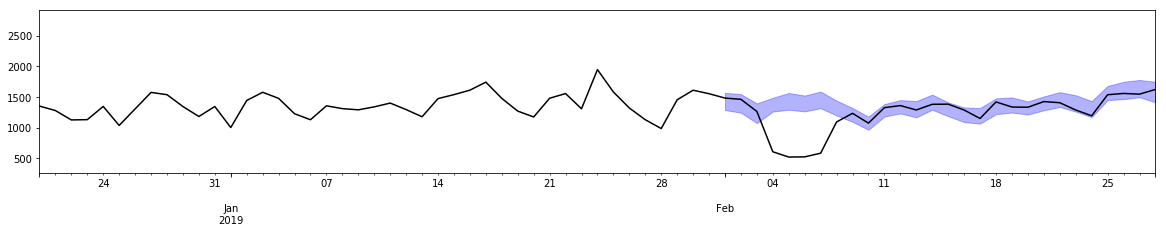

In [32]:
# Plot 4 of each category:
indices = [2,26,33,39,42,47,3]
for i in indices:
    plot_num = indices.index(i)
    plot(
        predictor,
        site_id=i,
        plot_weeks=6,
        confidence=80
    )

## Part 7. Remove the Endpoints

In [34]:
# Comment out this cell if you want the endpoint to exist after "run all"

# Comment out this line if you did NOT run the baseline code:
#sess.delete_endpoint('energy-usage-baseline')

sess.delete_endpoint('energy-usage-dynamic')